# **Lunch recommended system**

## import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
#from keras.utils import np_utils


## Import file

In [2]:
# import os
# from google.colab import drive

# # Get the identify of my google account
# drive.mount('/content/drive')

In [3]:
# os.chdir('/content/drive/My Drive/NTHU/Artificial_Intelligence/Final_project') # transfer to directory
# os.listdir() # Check the contect

## Data pre-processing

In [4]:
def ReadFile(file_path):
  df   = pd.read_csv(file_path)
  # data = df.to_numpy()
  return df

In [5]:
def dataSplit(X, y):
  X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.1, random_state=33)
  return X_train, X_validation, y_train, y_validation

In [6]:
def normalize(X):
  sc_X = StandardScaler()
  X_std = sc_X.fit_transform(X)
  return X_std

In [7]:


def label_encode(le, labels):
    enc = le.transform(labels)
    return np_utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

In [8]:

class MultiColumnLabelEncoder:
    def __init__(self, columns = None):
      self.columns = columns # array of column names to encode

    def fit(self, X, y=None):
      return self # not relevant here

    def transform(self, X):
      '''
      Transforms columns of X specified in self.columns using
      LabelEncoder(). If no columns specified, transforms all
      columns in X.
      '''
      output = X.copy()
      if self.columns is not None:
          for col in self.columns:
              output[col] = LabelEncoder().fit_transform(output[col])
      else:
          for colname,col in output.iteritems():
              output[colname] = LabelEncoder().fit_transform(col)
      return output

    def fit_transform(self, X, y=None):
      return self.fit(X,y).transform(X)

In [9]:
from sklearn.preprocessing import OneHotEncoder

class MultiColumnOneHotEncoder(object):

  def __init__(self, target_columns):
    '''
    :param: target_columns --- To perform one-hot encoding column name list. 
    '''
    self.enc = OneHotEncoder(handle_unknown='ignore')
    self.col_names = target_columns

  def fit(self, df):
    '''
    :param: df --- pandas DataFrame
    '''
    self.enc.fit(df[self.col_names].values)
    self.labels = np.array(self.enc.categories_).ravel()
    self.new_col_names = self.gen_col_names(df)

  def gen_col_names(self, df):
    '''
    :param:  df --- pandas DataFrame
    '''
    new_col_names = []
    for col in self.col_names:
      for val in df[col].unique():
        new_col_names.append("{}_{}".format(col, val))
    return new_col_names

  def transform(self, df):
     '''
     :param:  df --- pandas DataFrame
     '''
     return pd.DataFrame(data = self.enc.transform(df[self.col_names]).toarray(), 
                         columns = self.new_col_names, 
                         dtype=int) 

## Model

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
def RandomForest(X_train,y_train):
  parameter = {
          'max_features' : [2,3],
          'min_samples_leaf' : [3,4,5],
          'min_samples_split' : [8,10,12],
          'n_estimators' : [100,200,300,1000]
          }
  clf = GridSearchCV(RandomForestClassifier(), param_grid = parameter)
  clf = clf.fit(X_train,y_train)
  return clf

In [11]:
from sklearn import tree
def DecisionTree(X_train,y_train):
  clf=tree.DecisionTreeClassifier(criterion='entropy',max_depth=7)
  clf=clf.fit(X_train,y_train)

  return clf

In [12]:
from sklearn.neighbors import KNeighborsClassifier
def KNN(k, X_train,y_train):
  clf=KNeighborsClassifier(n_neighbors=k)
  clf=clf.fit(X_train,y_train)

  return clf

## Evaluation

In [13]:
# def evaluate(model, X_validation,y_validation):
#   results=model.predict(X_validation)
#   print("Score: ", model.score(X_validation,y_validation))
#   print("Results:\n", results)
#   print("y_validation:\n", y_validation)
#   return results

In [14]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import plot_tree
class Output:
  def __init__(self, model, X_validation, y_validation):
    self.model = model
    self.classification_report = classification_report
    self.X_validation = X_validation
    self.y_validation = y_validation
    self.results = self.model.predict(self.X_validation)
    self.results_decoder = list()

  def evaluate(self):
    # print("Score: ", self.model.score(self.X_validation,self.y_validation))
    print("Report:\n", self.classification_report(self.y_validation, self.results))
    print("Results:\n", self.results)
    print("y_validation:\n", self.y_validation)

  def drawTree(self):
    a = plot_tree(clf,
                  filled=True,
                  rounded=True,
                  fontsize=14)

  def le_decoder(self):
    # inverse the LabelEncode
    '''
    水木自助餐		               = 0
    校內便利商店		             = 1
    風雲樓二三樓		             = 2
    校外學校附近(清夜)            = 3
    清大小吃部                   = 4
    麥當勞			                = 5
    外送(Uber Eats, Foodpanda)  = 6
    '''
    for i, res in enumerate(self.results):
        if res == 0:
            self.results_decoder.append('水木自助餐')
        elif res == 1:
            self.results_decoder.append('校內便利商店')
        elif res == 2:
            self.results_decoder.append('風雲樓二三樓')
        elif res == 3:
            self.results_decoder.append('校外學校附近(清夜)')
        elif res == 4:
            self.results_decoder.append('清大小吃部')
        elif res == 5:
            self.results_decoder.append('麥當勞')
        elif res == 6:
            self.results_decoder.append('外送(Uber Eats, Foodpanda)')

    print("Before transfer:\n", self.results)
    print("After transfer:\n", self.results_decoder)
    return self.results_decoder

## Main

In [15]:
# # Make pandas table look better
# from google.colab import data_table
# data_table.enable_dataframe_formatter()

In [16]:
# Read the data 
data = ReadFile('20220113.csv')
data

,時間戳記,性別,身份,在清華讀了幾年？,今天午餐前你的位置？,今天是否吃早餐？,是否正在控制熱量攝取？（健身、減重等）,預算,今天早上天氣？,溫度,今天午餐決定在哪裡吃？,梁銘紘,Email,科系
0,12/21/2021 15:07:43,男,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,是,是,50-100元,小雨,寒冷,水木自助餐,梁銘紘,ray110033571@gapp.nthu.edu.tw,動機系
1,12/21/2021 15:07:55,男,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,否,否,50-100元,小雨,寒冷,校內便利商店,蕭靖澂,im.cchsiao@gmail.com,動機所
2,12/21/2021 15:07:58,男,碩士,0-2年,B區（學餐、宿舍）,是,否,50-100元,小雨,普通,風雲樓二三樓,游子顥,NaN,動機系
3,12/21/2021 15:08:02,男,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,否,否,100-200元,小雨,寒冷,校外學校附近（清夜）,陸仕昀,aceii871022@gmail.com,動機系
4,12/21/2021 15:08:11,女,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,是,否,50-100元,小雨,普通,校內便利商店,趙宇涵,honey0703@gmail.com,動機系
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,1/13/2022 12:56:57,男,大學生,2年以上,A區（工一館、台達館、行政大樓、圖書館）,是,是,50-100元,晴天,炎熱,清大小吃部,全貫中,tyshneverfade@gmail.com,材料
425,1/13/2022 12:58:37,女,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,是,否,50-100元,陰天,寒冷,校內便利商店,NaN,NaN,NaN
426,1/13/2022 12:59:03,男,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,否,否,50-100元,陰天,寒冷,校外學校附近（清夜）,NaN,NaN,NaN
427,1/13/2022 13:01:17,男,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,是,否,100-200元,陰天,寒冷,校內便利商店,黃宏澤,mic40613@gmail.com,化學系


In [17]:
# Rename the columns
data = data.rename(index=str, columns={"時間戳記":"Write_Time", "性別":"Gender", "身份":"Identity", "在清華讀了幾年？":"Time", "今天午餐前你的位置？":"Location", "今天是否吃早餐？":"Breakfirst", "是否正在控制熱量攝取？（健身、減重等）":"Controlling", "預算":"Budget", "今天早上天氣？":"Weather", "溫度":"Temperature", "今天午餐決定在哪裡吃？":"Target", "梁銘紘":"Name", "Email":"Email", "科系":"Department"})
data

,Write_Time,Gender,Identity,Time,Location,Breakfirst,Controlling,Budget,Weather,Temperature,Target,Name,Email,Department
0,12/21/2021 15:07:43,男,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,是,是,50-100元,小雨,寒冷,水木自助餐,梁銘紘,ray110033571@gapp.nthu.edu.tw,動機系
1,12/21/2021 15:07:55,男,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,否,否,50-100元,小雨,寒冷,校內便利商店,蕭靖澂,im.cchsiao@gmail.com,動機所
2,12/21/2021 15:07:58,男,碩士,0-2年,B區（學餐、宿舍）,是,否,50-100元,小雨,普通,風雲樓二三樓,游子顥,NaN,動機系
3,12/21/2021 15:08:02,男,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,否,否,100-200元,小雨,寒冷,校外學校附近（清夜）,陸仕昀,aceii871022@gmail.com,動機系
4,12/21/2021 15:08:11,女,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,是,否,50-100元,小雨,普通,校內便利商店,趙宇涵,honey0703@gmail.com,動機系
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,1/13/2022 12:56:57,男,大學生,2年以上,A區（工一館、台達館、行政大樓、圖書館）,是,是,50-100元,晴天,炎熱,清大小吃部,全貫中,tyshneverfade@gmail.com,材料
425,1/13/2022 12:58:37,女,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,是,否,50-100元,陰天,寒冷,校內便利商店,NaN,NaN,NaN
426,1/13/2022 12:59:03,男,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,否,否,50-100元,陰天,寒冷,校外學校附近（清夜）,NaN,NaN,NaN
427,1/13/2022 13:01:17,男,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,是,否,100-200元,陰天,寒冷,校內便利商店,黃宏澤,mic40613@gmail.com,化學系


In [18]:
# Clean the target, delete the 其他

for i, tar in enumerate(data['Target']):
  if tar == '其他':
    data = data.drop(index=[str(i)])

data

,Write_Time,Gender,Identity,Time,Location,Breakfirst,Controlling,Budget,Weather,Temperature,Target,Name,Email,Department
0,12/21/2021 15:07:43,男,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,是,是,50-100元,小雨,寒冷,水木自助餐,梁銘紘,ray110033571@gapp.nthu.edu.tw,動機系
1,12/21/2021 15:07:55,男,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,否,否,50-100元,小雨,寒冷,校內便利商店,蕭靖澂,im.cchsiao@gmail.com,動機所
2,12/21/2021 15:07:58,男,碩士,0-2年,B區（學餐、宿舍）,是,否,50-100元,小雨,普通,風雲樓二三樓,游子顥,NaN,動機系
3,12/21/2021 15:08:02,男,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,否,否,100-200元,小雨,寒冷,校外學校附近（清夜）,陸仕昀,aceii871022@gmail.com,動機系
4,12/21/2021 15:08:11,女,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,是,否,50-100元,小雨,普通,校內便利商店,趙宇涵,honey0703@gmail.com,動機系
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,1/13/2022 12:56:57,男,大學生,2年以上,A區（工一館、台達館、行政大樓、圖書館）,是,是,50-100元,晴天,炎熱,清大小吃部,全貫中,tyshneverfade@gmail.com,材料
425,1/13/2022 12:58:37,女,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,是,否,50-100元,陰天,寒冷,校內便利商店,NaN,NaN,NaN
426,1/13/2022 12:59:03,男,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,否,否,50-100元,陰天,寒冷,校外學校附近（清夜）,NaN,NaN,NaN
427,1/13/2022 13:01:17,男,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,是,否,100-200元,陰天,寒冷,校內便利商店,黃宏澤,mic40613@gmail.com,化學系


In [34]:
# Split the attributes and target
X = data.drop(columns=data.columns[[0, -1, -2, -3, -4]])
y = data.iloc[:, -4]
#print('attributes:\n', X[:10])
#print('\ntarget:\n', y[:10])
print(y)
y.to_csv('target.csv', header = None , index = None)

0      0
1      1
2      2
3      3
4      1
      ..
424    4
425    1
426    3
427    1
428    3
Name: Target, Length: 347, dtype: object


In [20]:
# Check each location's index
print(y.loc[y == '水木自助餐'][:1])
print(y.loc[y == '外送（Uber Eats, Foodpanda）'][:1])
print(y.loc[y == '校內便利商店'][:1])
print(y.loc[y == '校外學校附近（清夜）'][:1])
print(y.loc[y == '清大小吃部'][:1])
print(y.loc[y == '風雲樓二三樓'][:1])
print(y.loc[y == '麥當勞'][:1])

0    水木自助餐
Name: Target, dtype: object
58    外送（Uber Eats, Foodpanda）
Name: Target, dtype: object
1    校內便利商店
Name: Target, dtype: object
3    校外學校附近（清夜）
Name: Target, dtype: object
17    清大小吃部
Name: Target, dtype: object
2    風雲樓二三樓
Name: Target, dtype: object
27    麥當勞
Name: Target, dtype: object


In [21]:
# # Clean the attributes. (already cleaned)
# X = X.drop(columns=X.columns[[0, -1, -2, -3]])
X

,Gender,Identity,Time,Location,Breakfirst,Controlling,Budget,Weather,Temperature
0,男,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,是,是,50-100元,小雨,寒冷
1,男,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,否,否,50-100元,小雨,寒冷
2,男,碩士,0-2年,B區（學餐、宿舍）,是,否,50-100元,小雨,普通
3,男,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,否,否,100-200元,小雨,寒冷
4,女,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,是,否,50-100元,小雨,普通
...,...,...,...,...,...,...,...,...,...
424,男,大學生,2年以上,A區（工一館、台達館、行政大樓、圖書館）,是,是,50-100元,晴天,炎熱
425,女,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,是,否,50-100元,陰天,寒冷
426,男,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,否,否,50-100元,陰天,寒冷
427,男,碩士,0-2年,A區（工一館、台達館、行政大樓、圖書館）,是,否,100-200元,陰天,寒冷


In [22]:
# label_encoder = LabelEncoder()
# label_encoder.fit(y)
# print('check label: ', label_encoder.classes_)
# print('\n## Before convert')
# print('y[0:4]:\n', y[0:4])
# print('\ny.shape: ', y.shape)

# y = label_encode(label_encoder, y)

# print('\n\n## After convert')
# print('y[0:4]:\n', y[0:4])
# print('\ny.shape: ', y.shape)

In [23]:
# Label encoder
target = pd.Categorical(y.iloc[:], categories=y.iloc[:].unique(), ordered=True)
y.iloc[:] = target.codes

In [24]:
y[:10]

0    0
1    1
2    2
3    3
4    1
5    1
6    3
7    3
8    1
9    3
Name: Target, dtype: object

In [25]:
print("水木自助餐\t\t   = 0")
print("校內便利商店\t\t   = 1")
print("風雲樓二三樓\t\t   = 2")
print("校外學校附近（清夜）\t   = 3")
print("清大小吃部\t\t   = 4")
print("麥當勞\t\t\t   = 5")
print("外送（Uber Eats, Foodpanda) = 6")

水木自助餐		   = 0
校內便利商店		   = 1
風雲樓二三樓		   = 2
校外學校附近（清夜）	   = 3
清大小吃部		   = 4
麥當勞			   = 5
外送（Uber Eats, Foodpanda) = 6


In [26]:
print(y.loc[y == 6][:1])

58    6
Name: Target, dtype: object


In [27]:
# MulticolumnLabelEncoder
X = MultiColumnLabelEncoder().fit_transform(X) 
X

,Gender,Identity,Time,Location,Breakfirst,Controlling,Budget,Weather,Temperature
0,1,3,0,0,1,1,3,1,0
1,1,3,0,0,0,0,3,1,0
2,1,3,0,1,1,0,3,1,1
3,1,3,0,0,0,0,1,1,0
4,0,3,0,0,1,0,3,1,1
...,...,...,...,...,...,...,...,...,...
424,1,1,1,0,1,1,3,2,2
425,0,3,0,0,1,0,3,3,0
426,1,3,0,0,0,0,3,3,0
427,1,3,0,0,1,0,1,3,0


In [28]:
# MulticolumnOneHotEncoder
ONEHOT_COLUMNS =list(X.columns)

local_ohe = MultiColumnOneHotEncoder(ONEHOT_COLUMNS)
local_ohe.fit(X)
oht_df = local_ohe.transform(X)

# save to csv
oht_df.to_csv('20220113_oht.csv')
oht_df

/var/folders/kj/rln5s0_d7xnb_6k7gg9lv0g40000gn/T/ipykernel_90276/2488880221.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.labels = np.array(self.enc.categories_).ravel()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


,Gender_1,Gender_0,Identity_3,Identity_0,Identity_1,Identity_2,Time_0,Time_1,Location_0,Location_1,...,Budget_1,Budget_2,Budget_0,Weather_1,Weather_0,Weather_3,Weather_2,Temperature_0,Temperature_1,Temperature_2
0,0,1,0,0,0,1,1,0,1,0,...,0,0,1,0,1,0,0,1,0,0
1,0,1,0,0,0,1,1,0,1,0,...,0,0,1,0,1,0,0,1,0,0
2,0,1,0,0,0,1,1,0,0,1,...,0,0,1,0,1,0,0,0,1,0
3,0,1,0,0,0,1,1,0,1,0,...,1,0,0,0,1,0,0,1,0,0
4,1,0,0,0,0,1,1,0,1,0,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,0,1,0,1,0,0,0,1,1,0,...,0,0,1,0,0,1,0,0,0,1
343,1,0,0,0,0,1,1,0,1,0,...,0,0,1,0,0,0,1,1,0,0
344,0,1,0,0,0,1,1,0,1,0,...,0,0,1,0,0,0,1,1,0,0
345,0,1,0,0,0,1,1,0,1,0,...,1,0,0,0,0,0,1,1,0,0


In [33]:
# train test split
X_train, X_validation, y_train, y_validation = dataSplit(oht_df, y)
print(X_train.shape)
print(X_validation.shape)
print(y_train.shape)
print(y_validation.shape)
print(y_validation[:10])
X_validation.to_csv('test.csv',index=None)
X_train.to_csv('train.csv',index=None)
y_train.to_csv('train_sol.csv',index=None)
y_validation.to_csv('test_sol.csv',index=None)



(312, 28)
(35, 28)
(312,)
(35,)
125    4
351    0
375    4
260    3
4      1
173    3
324    0
366    0
338    4
383    0
Name: Target, dtype: object


0    110
1     32
2     27
3     96
4     65
5      9
6      8
Name: Target, dtype: int64


<AxesSubplot:title={'center':'Category distribution'}>

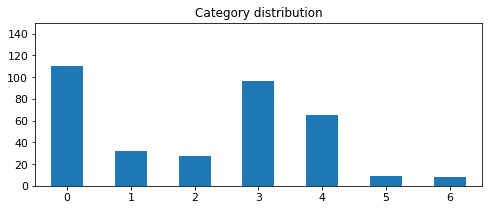

In [30]:
print(y.value_counts(sort=False))
y.value_counts(sort=False).plot(kind = 'bar',
                                title = 'Category distribution',
                                ylim = [0, 150],         #y axis limit
                                rot = 0, fontsize = 11, figsize = (8,3))
# 水木自助餐		     = 0
# 校內便利商店		   = 1
# 風雲樓二三樓		   = 2
# 校外學校附近(清夜)  = 3
# 清大小吃部		     = 4
# 麥當勞			      = 5
# 外送（Uber Eats, Foodpanda) = 6

In [31]:
# train and predict
clf = DecisionTree(X_train, y_train)

ValueError: Unknown label type: 'unknown'

In [ ]:
# evaluate
output = Output(clf, X_validation, y_validation)
output.evaluate()
output.drawTree()
tar = output.le_decoder()

In [ ]:
RF = RandomForest(X_train, y_train)

In [ ]:
knn = KNN(3, X_train, y_train)

In [ ]:
# evaluate
output = Output(RF, X_validation, y_validation)
output.evaluate()
tar = output.le_decoder()